In [11]:
import pandas as pd
import tensorflow as tf
import os
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [2]:
# data load
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# tokenizer
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 리스트

In [5]:
# data pre-processing
def load_data(train_data, test_data):
    # 중복, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # dictionary : word_to_index
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # list 단위로 처리하게 하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # text->index
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [75]:
# data load
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [76]:
print(word_to_index)

{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '서': 1

In [77]:
# index to word 생성
    #실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [78]:
print(len(index_to_word))
print(index_to_word)

10000
{3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105: '냐', 106: '재미없', 107:

In [8]:
# 문장 1개를 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
    # 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
# 데이터셋 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41


In [88]:
# 최대 문장 길이
max_length = 41

# padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_length)

In [23]:
# 모델 1. GlobalMaxPooling
vocab_size = len(index_to_word)
word_vector_dim = 16

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [24]:
# 모델 2. 1d CNN
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [25]:
# 모델 3. LSTM
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [89]:
# val set
x_val = X_train[:10000]   
y_val = y_train[:10000]

In [51]:
# 모델 훈련 : 1
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history1 = model1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0990 - accuracy: 0.9690 - val_loss: 0.0794 - val_accuracy: 0.9767
Epoch 2/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9702 - val_loss: 0.0780 - val_accuracy: 0.9777
Epoch 3/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0925 - accuracy: 0.9714 - val_loss: 0.0773 - val_accuracy: 0.9771
Epoch 4/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0907 - accuracy: 0.9721 - val_loss: 0.0734 - val_accuracy: 0.9791
Epoch 5/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0888 - accuracy: 0.9731 - val_loss: 0.0742 - val_accuracy: 0.9773
Epoch 6/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0874 - accuracy: 0.9735 - val_loss: 0.0722 - val_accuracy: 0.9790
Epoch 7/30
286/286 [==============================] - 1s 3ms/step - loss: 0.0860 - accuracy: 0.9739 - val_loss: 0.0713 - val_accuracy: 0.9794
Epoch 

In [52]:
# 모델 훈련 : 2
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
286/286 [==============================] - 2s 5ms/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0206 - val_accuracy: 0.9934
Epoch 2/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0189 - val_accuracy: 0.9947
Epoch 3/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0189 - val_accuracy: 0.9943
Epoch 4/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.0202 - val_accuracy: 0.9939
Epoch 5/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0195 - val_accuracy: 0.9939
Epoch 6/30
286/286 [==============================] - 1s 4ms/step - loss: 0.0222 - accuracy: 0.9924 - val_loss: 0.0229 - val_accuracy: 0.9933
Epoch 7/30
286/286 [==============================] - 1s 5ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0236 - val_accuracy: 0.9913
Epoch 

In [53]:
# 모델 훈련 : 3
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
286/286 [==============================] - 3s 6ms/step - loss: 0.1132 - accuracy: 0.9580 - val_loss: 0.0947 - val_accuracy: 0.9661
Epoch 2/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1077 - accuracy: 0.9606 - val_loss: 0.0945 - val_accuracy: 0.9645
Epoch 3/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1064 - accuracy: 0.9613 - val_loss: 0.0961 - val_accuracy: 0.9658
Epoch 4/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1061 - accuracy: 0.9613 - val_loss: 0.0891 - val_accuracy: 0.9681
Epoch 5/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1043 - accuracy: 0.9614 - val_loss: 0.0952 - val_accuracy: 0.9649
Epoch 6/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1020 - accuracy: 0.9623 - val_loss: 0.1124 - val_accuracy: 0.9576
Epoch 7/30
286/286 [==============================] - 1s 5ms/step - loss: 0.1029 - accuracy: 0.9621 - val_loss: 0.0852 - val_accuracy: 0.9697
Epoch 

In [42]:
# loss, acc 그래프 뽑는 함수
import matplotlib.pyplot as plt

def loss_acc_graph(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.plot(epochs, loss, 'bo', label='Training loss')     # "bo"는 "파란색 점", b는 "파란 실선"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

1537/1537 - 2s - loss: 1.2272 - accuracy: 0.8013
[1.2271851301193237, 0.8012897372245789]


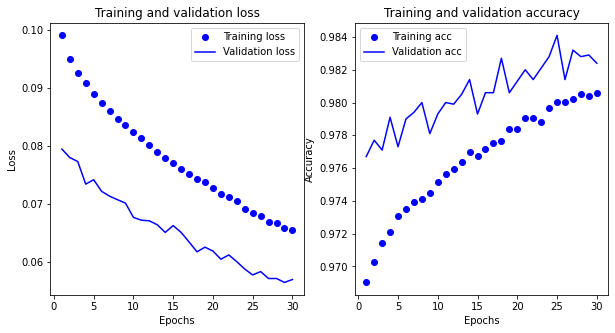

1537/1537 - 2s - loss: 2.0341 - accuracy: 0.8057
[2.0340774059295654, 0.8057448863983154]


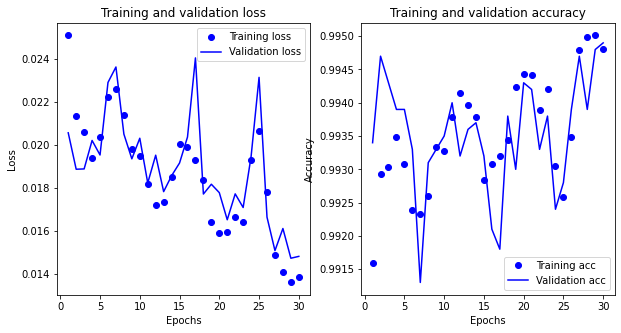

1537/1537 - 3s - loss: 1.1488 - accuracy: 0.8214
[1.1487716436386108, 0.8214496374130249]


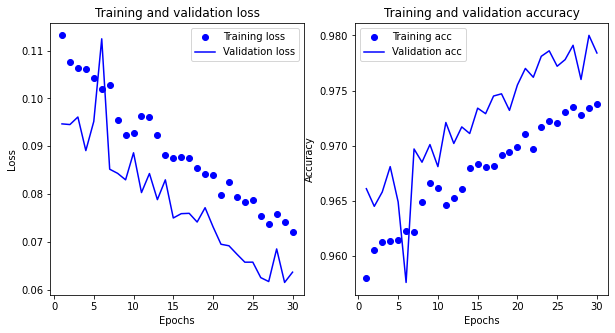

In [54]:
# 모델 평가, 그래프 출력
    # model1
results1 = model1.evaluate(X_test,  y_test, verbose=2)
print(results1)
loss_acc_graph(history1.history)
    # model2
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)
loss_acc_graph(history2.history)
    # model3
results3 = model3.evaluate(X_test,  y_test, verbose=2)
print(results3)
loss_acc_graph(history3.history)

In [47]:
# 한국어 word2vec 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)

In [82]:
print(word_vectors.wv['끝'])

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [84]:
vocab_size = 10000    # 어휘 사전의 크기(100,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [85]:
# model 1,2,3 재구성
from tensorflow.keras.initializers import Constant
# model 1. GlobalMaxPooling1D
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_length, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model 2. 1D CNN
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=max_length, 
                                 trainable=True))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
# model 3. LSTM
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=max_length, 
                                 trainable=True))
model3.add(tf.keras.layers.LSTM(8))
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [90]:
# 모델 훈련 : 1
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=30
history1 = model1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# 모델 훈련 : 2
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# 모델 훈련 : 3
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
286/286 [==============================] - 2s 4ms/step - loss: 0.7368 - accuracy: 0.5211 - val_loss: 0.6900 - val_accuracy: 0.5343
Epoch 2/30
286/286 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5757 - val_loss: 0.6642 - val_accuracy: 0.6178
Epoch 3/30
286/286 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6464 - val_loss: 0.6204 - val_accuracy: 0.6755
Epoch 4/30
286/286 [==============================] - 1s 4ms/step - loss: 0.5935 - accuracy: 0.6941 - val_loss: 0.5610 - val_accuracy: 0.7137
Epoch 5/30
286/286 [==============================] - 1s 4ms/step - loss: 0.5419 - accuracy: 0.7291 - val_loss: 0.5223 - val_accuracy: 0.7409
Epoch 6/30
286/286 [==============================] - 1s 4ms/step - loss: 0.5089 - accuracy: 0.7523 - val_loss: 0.4925 - val_accuracy: 0.7627
Epoch 7/30
286/286 [==============================] - 1s 4ms/step - loss: 0.4832 - accuracy: 0.7692 - val_loss: 0.4707 - val_accuracy: 0.7771
Epoch 

1537/1537 - 2s - loss: 0.4072 - accuracy: 0.8208
[0.40720778703689575, 0.8207783102989197]


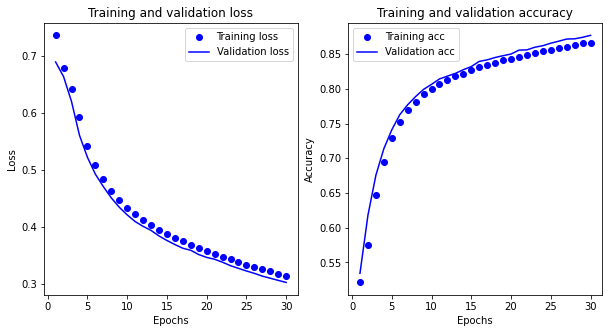

1537/1537 - 3s - loss: 0.6881 - accuracy: 0.8316
[0.6881126761436462, 0.8316211104393005]


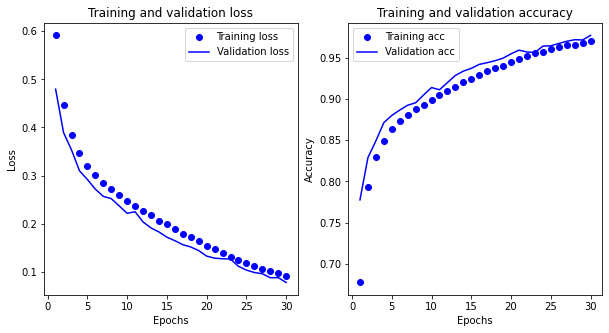

1537/1537 - 3s - loss: 0.4821 - accuracy: 0.8365
[0.4820728600025177, 0.8365237712860107]


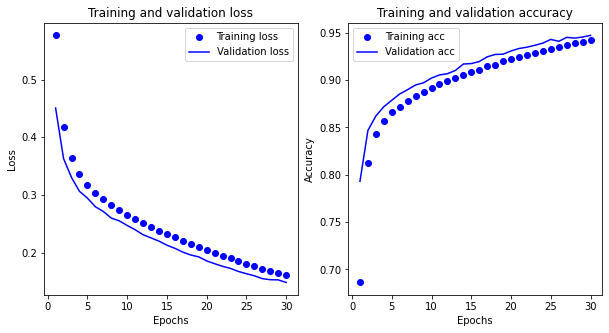

In [92]:
# 모델 평가, 그래프 출력
    # model1
results1 = model1.evaluate(X_test,  y_test, verbose=2)
print(results1)
loss_acc_graph(history1.history)
    # model2
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)
loss_acc_graph(history2.history)
    # model3
results3 = model3.evaluate(X_test,  y_test, verbose=2)
print(results3)
loss_acc_graph(history3.history)

In [ ]:
# 회고
"""
word2vec을 사용하니 loss, acc 곡선도 더 안정적이고, 테스트 성능도 아주 약간 올랐다.
"""